C:\Users\Nilsl\AppData\Local\Temp\ipykernel_9800\2218620142.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xy_train[:, :, 0], xy_train[:, :, 1], cmap='hsv', s=1)


(10000, 100, 2)
(10000, 1)
(10000, 100, 2)


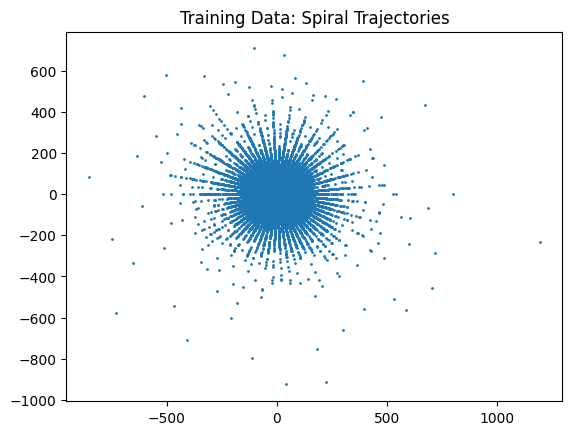

xy_norm shape: [[[-1.3425372e-05 -1.5320942e-04]
  [-5.2129768e-02 -1.0401086e-02]
  [-6.9177844e-02 -2.8402818e-02]
  ...
  [-5.5069170e+00  2.2490942e+00]
  [-3.5734904e+00  7.0251608e-01]
  [-5.8230047e+00 -1.5320942e-04]]

 [[-1.3425372e-05 -1.5320942e-04]
  [ 1.2320579e-02  2.2720827e-03]
  [ 3.2359481e-02  1.3069224e-02]
  ...
  [ 1.0404962e+00 -4.2514038e-01]
  [ 1.4234835e+00 -2.8006196e-01]
  [ 1.6391985e+00 -1.5320942e-04]]

 [[-1.3425372e-05 -1.5320942e-04]
  [-2.5499802e-02 -5.1647131e-03]
  [-3.8330507e-02 -1.5803492e-02]
  ...
  [-2.1143448e+00  8.6342722e-01]
  [-2.0266342e+00  3.9835057e-01]
  [-2.9603000e+00 -1.5320942e-04]]

 ...

 [[-1.3425372e-05 -1.5320942e-04]
  [ 1.7113455e-02  3.2145279e-03]
  [ 2.6770536e-02  1.0786469e-02]
  ...
  [ 1.2105616e+00 -4.9460211e-01]
  [ 1.3925500e+00 -2.7397934e-01]
  [ 1.2772022e+00 -1.5320942e-04]]

 [[-1.3425372e-05 -1.5320942e-04]
  [-9.6650720e-03 -2.0510573e-03]
  [-1.8435311e-02 -7.6774699e-03]
  ...
  [-7.7804470e-01  3.17

In [ ]:
import time
import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import optax
import numpy as np


# import dataset 'spirals.npz' from local directory
data = np.load('spirals.npz')
xy_train = data['xy_train']
alpha_train = data['alpha_train']
xy_test = data['xy_test']
#plot xy_train (Training data of shape (10000, 100, 2). This represents 10,000 spiral trajectories, each with 100 time points and 2 spatial dimensions (x, y).)
plt.scatter(xy_train[:, :, 0], xy_train[:, :, 1], cmap='hsv', s=1)
plt.title('Training Data: Spiral Trajectories')
print(xy_train.shape)
print(alpha_train.shape)
print(xy_test.shape)
plt.show()


data = np.load("spirals.npz")
xy = data["xy_train"].astype(np.float32)   # (N, T, D)
alpha = data["alpha_train"].astype(np.float32)

# compute train stats
mean = xy.mean(axis=(0,1), keepdims=True)   # shape (1,1,D)
std  = xy.std(axis=(0,1), keepdims=True)
xy_norm = (xy - mean) / (std + 1e-6)

alpha_mean = alpha.mean()
alpha_std  = alpha.std()
alpha_norm = (alpha - alpha_mean) / (alpha_std + 1e-6)

# convert to jax
xy_norm = jnp.array(xy_norm)
alpha_norm = jnp.array(alpha_norm)

T = xy_norm.shape[1]
t = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)   # shape (T,)
# Now, xy_norm contains the normalized spiral trajectories, and alpha_norm contains the normalized parameters.

batch_size = 128

def batch_generator(xy, alpha, batch_size, shuffle=True):
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        batch_idx = idx[i:i+batch_size]
        yield xy[batch_idx], alpha[batch_idx]

global def target(params, h, alpha):



def train_step(params, opt_state, x_batch, t, key):
    def loss_fn(params):
        h = encoder_init(params, x_batch[:, 0, :])   # (B, h_dim)
        total_loss = 0.0
        for i in range(T-1):
            # integrate from t[i] to t[i+1]
            sol = diffeqsolve(ODETerm(ode_func(params)), solver, t0=t[i], t1=t[i+1], y0=h)
            h = sol.ys[-1]
            # predict next-step
            y_pred = decoder(params, h)   # (B, D)
            total_loss += ((y_pred - x_batch[:, i+1, :])**2).mean()
            # RNN update with observed x at i+1
            h = rnn_cell(params, x_batch[:, i+1, :], h)
        return total_loss / (T-1)

    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state



In [ ]:
# ode_rnn_alpha_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
data = np.load("spirals.npz")
xy_train = data["xy_train"].astype(np.float32)   # (N, T, 2)
alpha_train = data["alpha_train"].astype(np.float32)  # (N, 1)
xy_test = data["xy_test"].astype(np.float32)

N, T, D = xy_train.shape
assert D == 2

# normalize inputs (per-dimension)
xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
xy_train_n = (xy_train - xy_mean) / xy_std
xy_test_n  = (xy_test - xy_mean) / xy_std

alpha_mean = alpha_train.mean(axis=0, keepdims=True)
alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
alpha_train_n = (alpha_train - alpha_mean) / alpha_std

# convert to jax
xy_train_n = jnp.array(xy_train_n)
alpha_train_n = jnp.array(alpha_train_n)
xy_test_n = jnp.array(xy_test_n)

# temporal grid: assume observations evenly spaced in [0,1]
t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

# Model components (Equinox)

class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        x = jnp.atleast_2d(x0)      # (B, in_size) oder (1, in_size)
        # direct call: eqx.nn.MLP unterstützt batched inputs
        out = self.net(x)          # -> (B, out_size)
        # optional assert (nur zum Debuggen)
        # assert out.shape[0] == x.shape[0] and out.shape[1] == self.net.out_size
        return out
    
def ensure_batched(x):
    x = jnp.asarray(x)
    if x.ndim == 0:
        return x.reshape((1, 1))
    if x.ndim == 1:
        return x[None, :]
    return x


class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        # Das MLP erwartet jetzt h_dim (Zustand) + 1 (Zeit)
        self.net = eqx.nn.MLP(h_dim + 1, h_dim, width_size=128, depth=2, key=key)

    def __call__(self, t, h, args):
        # h ist jetzt (h_dim,)
        # t ist ein Skalar
        
        # t in einen Vektor der Form (1,) umwandeln
        t_feat = jnp.atleast_1d(t) 
        
        # h und t_feat verketten
        inp = jnp.concatenate([h, t_feat]) # -> (h_dim + 1,)
        out = self.net(inp)                # -> (h_dim,)
        return out

class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = jnp.atleast_2d(h)   # (B, h_dim)
        out = self.net(h_mat)       # -> (B, out_dim)
        return out


class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x = jnp.atleast_2d(x)   # (B, x_dim)
        h = jnp.atleast_2d(h)   # (B, h_dim)
        gates = self.lin_x(x) + self.lin_h(h)  # (B, 3*h_dim)
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z); r = jnn.sigmoid(r); o = jnp.tanh(o)
        h_new = (1 - z) * h + z * o
        return h_new

class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim

# Solver and utils
# Put tolerances on solver construction to avoid passing rtol/atol into diffeqsolve
# Solver and utils (robuste Version mit dt0)

solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
# Den Controller hier definieren, um ihn wiederzuverwenden
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)
# Der ODETerm wird jetzt außerhalb der Verlustfunktion definiert
# und nimmt das *statische* ODERNN-Modell entgegen
term = diffrax.ODETerm(ODEFunc(h_dim=h_dim, key=jax.random.PRNGKey(0))) # Dummy-Key, wird überschrieben

def mse(a, b):
    return jnp.mean((a - b) ** 2)

def solve_ode_vmap(odefunc, h0, t0, t1):
    """Löst die ODE für einen einzelnen Batch-Eintrag."""
    term = diffrax.ODETerm(odefunc)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        y0=h0,
        args=None, # odefunc ist jetzt der Term selbst
        dt0=None,  # Automatisch
        stepsize_controller=stepsize_controller,
        adjoint=adjoint,
    )
    # sol.ys hat die Form (1, h_dim)
    return sol.ys[-1]

def sequence_loss(params, model: ODERNN, x_seq, alpha_true):
    # x_seq: (B, T, D)
    B = x_seq.shape[0]
    
    # Ersetze die statischen Teile des Modells (die Odefunc) 
    # mit den trainierbaren Parametern
    model = eqx.combine(model, params)
    
    h = jax.vmap(model.encoder)(x_seq[:, 0, :])  # (B, h_dim)
    
    # vmap-bare Funktion zum Lösen der ODE
    vmapped_solve = jax.vmap(solve_ode_vmap, in_axes=(None, 0, None, None))
    
    for i in range(T - 1):
        # Führe die ODE-Integration für den gesamten Batch mit vmap aus
        h = vmapped_solve(model.odefunc, h, float(t_grid[i]), float(t_grid[i+1]))
        
        # Führe den RNN-Update für den gesamten Batch aus (RNNUpdate unterstützt Batching)
        h = model.rnn_update(x_seq[:, i+1, :], h)
        
    # Decoder für den gesamten Batch (Decoder unterstützt Batching)
    alpha_pred = model.decoder(h)  # (B,1)
    loss = mse(alpha_pred, alpha_true)
    return loss, alpha_pred

def loss_and_grad(model, x_batch, alpha_batch):
    # Filtere nur die trainierbaren Parameter (Arrays) heraus
    params = eqx.filter(model, eqx.is_array)
    
    def _loss_fn(p):
        # Übergebe die Parameter an sequence_loss
        l, _ = sequence_loss(p, model, x_batch, alpha_batch)
        
        # Weight decay
        leaves = jax.tree_util.tree_leaves(p)
        l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
        return l + l2
        
    # Berechne den Gradienten bezüglich der Parameter 'params'
    loss_val, grads = eqx.filter_value_and_grad(_loss_fn)(params)
    return loss_val, grads

# Training loop
key = random.PRNGKey(0)
h_dim = 64
model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

# optimizer
learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
# Opt-State wird auf die trainierbaren Parameter initialisiert
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 128
num_epochs = 30

def data_loader(xy, alpha, batch_size, shuffle=True):
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        b = idx[i:i+batch_size]
        yield xy[b], alpha[b]

# -----------------------------
# ANGEPASSTE FUNKTION: apply_updates
# -----------------------------
@jax.jit
def apply_updates(model, grads, opt_state):
    # Filtere die Parameter, die aktualisiert werden sollen
    params = eqx.filter(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    # Wende Updates auf das Modell an
    model = eqx.apply_updates(model, updates)
    return model, opt_state

for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    losses = []
    for xb, ab in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
        xb_j = jnp.array(xb)
        ab_j = jnp.array(ab)
        loss_val, grads = loss_and_grad(model, xb_j, ab_j)
        model, opt_state = apply_updates(model, grads, opt_state)
        losses.append(float(loss_val))
    t1 = time.time()
    print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")


# -----------------------------
# ANGEPASSTE FUNKTION: predict_alpha
# -----------------------------
def predict_alpha(model, xy_input):
    # xy_input: (N, T, D) normalized
    batch_size = 128
    preds = []
    
    # Definiere die vmap-bare Solve-Funktion (genau wie im Training)
    vmapped_solve = jax.vmap(solve_ode_vmap, in_axes=(None, 0, None, None))

    for i in range(0, xy_input.shape[0], batch_size):
        xb = xy_input[i:i+batch_size]
        B = xb.shape[0]
        
        # Encoder (unterstützt Batching)
        h = model.encoder(xb[:, 0, :])
        
        for j in range(T - 1):
            # ODE-Integration per vmap
            h = vmapped_solve(model.odefunc, h, float(t_grid[j]), float(t_grid[j+1]))
            # RNN-Update (unterstützt Batching)
            h = model.rnn_update(xb[:, j+1, :], h)
            
        # Decoder (unterstützt Batching)
        alpha_p = model.decoder(h)  # (B,1) normalized
        preds.append(np.array(alpha_p))
        
    preds = np.vstack(preds)
    # denormalize
    preds_orig = preds * alpha_std + alpha_mean
    return preds_orig

# ... [Der restliche Code (Saving, Plotting) bleibt gleich] ...

# Schnelle Anpassung für die Plot-Schleife am Ende
idx = 0
xb = xy_train_n[idx:idx+1]  # (1, T, D)
h = model.encoder(xb[:, 0, :]) # (1, h_dim)
alphas_steps = []

# vmap-bare Funktion (auch für Batch-Größe 1)
vmapped_solve = jax.vmap(solve_ode_vmap, in_axes=(None, 0, None, None))

for j in range(T - 1):
    h = vmapped_solve(model.odefunc, h, float(t_grid[j]), float(t_grid[j+1]))
    h = model.rnn_update(xb[:, j+1, :], h)
    a = np.array(model.decoder(h))[0,0] * alpha_std + alpha_mean
    alphas_steps.append(float(a))

true_alpha_val = float(alpha_train[idx, 0])
plt.figure()
plt.plot(np.arange(len(alphas_steps)), alphas_steps, label="predicted alpha (per step)")
plt.hlines(true_alpha_val, 0, len(alphas_steps)-1, colors='r', linestyles='--', label="true alpha")
plt.xlabel("time step")
plt.ylabel("alpha")
plt.legend()
plt.title(f"Alpha over time for example {idx}")
plt.show()




TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (1,).

In [41]:
# ode_rnn_alpha_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
data = np.load("spirals.npz")
xy_train = data["xy_train"].astype(np.float32)   # (N, T, 2)
alpha_train = data["alpha_train"].astype(np.float32)  # (N, 1)
xy_test = data["xy_test"].astype(np.float32)

N, T, D = xy_train.shape
assert D == 2

# normalize inputs (per-dimension)
xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
xy_train_n = (xy_train - xy_mean) / xy_std
xy_test_n  = (xy_test - xy_mean) / xy_std

alpha_mean = alpha_train.mean(axis=0, keepdims=True)
alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
alpha_train_n = (alpha_train - alpha_mean) / alpha_std

# convert to jax
xy_train_n = jnp.array(xy_train_n)
alpha_train_n = jnp.array(alpha_train_n)
xy_test_n = jnp.array(xy_test_n)

# temporal grid: assume observations evenly spaced in [0,1]
t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

# Model components (Equinox)

class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        x = jnp.atleast_2d(x0)      # (B, in_size) oder (1, in_size)
        # direct call: eqx.nn.MLP unterstützt batched inputs
        out = self.net(x)          # -> (B, out_size)
        return out

class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        # Das MLP erwartet jetzt h_dim (Zustand) + 1 (Zeit)
        self.net = eqx.nn.MLP(h_dim + 1, h_dim, width_size=128, depth=2, key=key)

    def __call__(self, t, h, args):
        # h ist jetzt (h_dim,)
        # t ist ein Skalar
        
        # t in einen Vektor der Form (1,) umwandeln
        t_feat = jnp.atleast_1d(t) 
        
        # h und t_feat verketten
        inp = jnp.concatenate([h, t_feat]) # -> (h_dim + 1,)
        out = self.net(inp)                # -> (h_dim,)
        return out

class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = jnp.atleast_2d(h)  # (B, h_dim)
        out = self.net(h_mat)      # -> (B, out_dim)
        return out


class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x = jnp.atleast_2d(x)  # (B, x_dim)
        h = jnp.atleast_2d(h)  # (B, h_dim)
        gates = self.lin_x(x) + self.lin_h(h)  # (B, 3*h_dim)
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z); r = jnn.sigmoid(r); o = jnp.tanh(o)
        h_new = (1 - z) * h + z * o
        return h_new

class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim

# Solver and utils
solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)

def mse(a, b):
    return jnp.mean((a - b) ** 2)

def solve_ode_vmap(odefunc, h0, t0, t1):
    """Löst die ODE für einen einzelnen Batch-Eintrag."""
    term = diffrax.ODETerm(odefunc)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        y0=h0,
        args=None, # odefunc ist jetzt der Term selbst
        dt0=None,  # Automatisch
        stepsize_controller=stepsize_controller,
        adjoint=adjoint,
    )
    # sol.ys hat die Form (1, h_dim)
    return sol.ys[-1]

def sequence_loss(params, model: ODERNN, x_seq, alpha_true):
    # x_seq: (B, T, D)
    B = x_seq.shape[0]
    
    # Ersetze die statischen Teile des Modells (die Odefunc) 
    # mit den trainierbaren Parametern
    model = eqx.combine(model, params)
    
    # -----------------------------------------------------------------
    # KORREKTUR HIER: jax.vmap entfernt, da Encoder Batching unterstützt
    # -----------------------------------------------------------------
    h = model.encoder(x_seq[:, 0, :])  # (B, h_dim)
    
    # vmap-bare Funktion zum Lösen der ODE
    vmapped_solve = jax.vmap(solve_ode_vmap, in_axes=(None, 0, None, None))
    
    for i in range(T - 1):
        # Führe die ODE-Integration für den gesamten Batch mit vmap aus
        h = vmapped_solve(model.odefunc, h, float(t_grid[i]), float(t_grid[i+1]))
        
        # Führe den RNN-Update für den gesamten Batch aus (RNNUpdate unterstützt Batching)
        h = model.rnn_update(x_seq[:, i+1, :], h)
        
    # Decoder für den gesamten Batch (Decoder unterstützt Batching)
    alpha_pred = model.decoder(h)  # (B,1)
    loss = mse(alpha_pred, alpha_true)
    return loss, alpha_pred

def loss_and_grad(model, x_batch, alpha_batch):
    # Filtere nur die trainierbaren Parameter (Arrays) heraus
    params = eqx.filter(model, eqx.is_array)
    
    def _loss_fn(p):
        # Übergebe die Parameter an sequence_loss
        l, _ = sequence_loss(p, model, x_batch, alpha_batch)
        
        # Weight decay
        leaves = jax.tree_util.tree_leaves(p)
        l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
        return l + l2
        
    # Berechne den Gradienten bezüglich der Parameter 'params'
    loss_val, grads = eqx.filter_value_and_grad(_loss_fn)(params)
    return loss_val, grads

# Training loop
key = random.PRNGKey(0)
h_dim = 64
model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

# optimizer
learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
# Opt-State wird auf die trainierbaren Parameter initialisiert
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 128
num_epochs = 30

def data_loader(xy, alpha, batch_size, shuffle=True):
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        b = idx[i:i+batch_size]
        yield xy[b], alpha[b]

@jax.jit
def apply_updates(model, grads, opt_state):
    # Filtere die Parameter, die aktualisiert werden sollen
    params = eqx.filter(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    # Wende Updates auf das Modell an
    model = eqx.apply_updates(model, updates)
    return model, opt_state

for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    losses = []
    for xb, ab in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
        xb_j = jnp.array(xb)
        ab_j = jnp.array(ab)
        loss_val, grads = loss_and_grad(model, xb_j, ab_j)
        model, opt_state = apply_updates(model, grads, opt_state)
        losses.append(float(loss_val))
    t1 = time.time()
    print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")


def predict_alpha(model, xy_input):
    # xy_input: (N, T, D) normalized
    batch_size = 128
    preds = []
    
    # Definiere die vmap-bare Solve-Funktion (genau wie im Training)
    vmapped_solve = jax.vmap(solve_ode_vmap, in_axes=(None, 0, None, None))

    for i in range(0, xy_input.shape[0], batch_size):
        xb = xy_input[i:i+batch_size]
        B = xb.shape[0]
        
        # Encoder (unterstützt Batching)
        h = model.encoder(xb[:, 0, :])
        
        for j in range(T - 1):
            # ODE-Integration per vmap
            h = vmapped_solve(model.odefunc, h, float(t_grid[j]), float(t_grid[j+1]))
            # RNN-Update (unterstützt Batching)
            h = model.rnn_update(xb[:, j+1, :], h)
            
        # Decoder (unterstützt Batching)
        alpha_p = model.decoder(h)  # (B,1) normalized
        preds.append(np.array(alpha_p))
        
    preds = np.vstack(preds)
    # denormalize
    preds_orig = preds * alpha_std + alpha_mean
    return preds_orig

alpha_test_pred = predict_alpha(model, xy_test_n)  # shape (N,1)
np.save("alpha_test_pred.npy", alpha_test_pred)
print("Saved alpha_test_pred.npy with shape", alpha_test_pred.shape)

# optional quick eval on train set (to sanity-check) and plot
subset = 200
train_pred = predict_alpha(model, xy_train_n[:subset])
train_true = np.array(alpha_train[:subset])

plt.figure(figsize=(6,6))
plt.scatter(train_true.ravel(), train_pred.ravel(), alpha=0.6, s=20, label="pred vs true")
minv = min(train_true.min(), train_pred.min())
maxv = max(train_true.max(), train_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', label="identity")
plt.xlabel("alpha true")
plt.ylabel("alpha predicted")
plt.legend()
plt.title("Predicted alpha vs True alpha (subset)")
plt.show()

# Example: alpha over time for a single example (predicted after each step) and compare to true alpha
idx = 0
xb = xy_train_n[idx:idx+1]  # (1, T, D)
h = model.encoder(xb[:, 0, :]) # (1, h_dim)
alphas_steps = []

# vmap-bare Funktion (auch für Batch-Größe 1)
vmapped_solve = jax.vmap(solve_ode_vmap, in_axes=(None, 0, None, None))

for j in range(T - 1):
    h = vmapped_solve(model.odefunc, h, float(t_grid[j]), float(t_grid[j+1]))
    h = model.rnn_update(xb[:, j+1, :], h)
    a = np.array(model.decoder(h))[0,0] * alpha_std + alpha_mean
    alphas_steps.append(float(a))

true_alpha_val = float(alpha_train[idx, 0])
plt.figure()
plt.plot(np.arange(len(alphas_steps)), alphas_steps, label="predicted alpha (per step)")
plt.hlines(true_alpha_val, 0, len(alphas_steps)-1, colors='r', linestyles='--', label="true alpha")
plt.xlabel("time step")
plt.ylabel("alpha")
plt.legend()
plt.title(f"Alpha over time for example {idx}")
plt.show()

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (128,).

In [1]:
# ode_rnn_alpha_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
data = np.load("spirals.npz")
xy_train = data["xy_train"].astype(np.float32)   # (N, T, 2)
alpha_train = data["alpha_train"].astype(np.float32)  # (N, 1)
xy_test = data["xy_test"].astype(np.float32)

N, T, D = xy_train.shape
assert D == 2

# normalize inputs (per-dimension)
xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
xy_train_n = (xy_train - xy_mean) / xy_std
xy_test_n  = (xy_test - xy_mean) / xy_std

alpha_mean = alpha_train.mean(axis=0, keepdims=True)
alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
alpha_train_n = (alpha_train - alpha_mean) / alpha_std

# convert to jax
xy_train_n = jnp.array(xy_train_n)
alpha_train_n = jnp.array(alpha_train_n)
xy_test_n = jnp.array(xy_test_n)

# temporal grid: assume observations evenly spaced in [0,1]
t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

# Model components (Equinox)

# Cell In[43], line 50
class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        # KORRIGIERT: Entferne jnp.atleast_2d und die squeeze-Logik.
        # MLP verarbeitet 1D-Vektoren (aus vmap) oder 2D-Batches (direkter Aufruf)
        # korrekt, solange wir nicht versuchen, 1D zu 2D zu zwingen.
        out = self.net(x0) # x0 ist entweder (D,) (innerhalb von vmap) oder (B, D)
        return out                  # -> (B, out_size)
# -----------------------------------------------------------------
# KORRIGIERTE KLASSE: ODEFunc (zurück zum Original)
# -----------------------------------------------------------------
# Cell In[48], line 64
# Cell In[...], ODEFunc Class
class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        # WICHTIG: in_size muss h_dim + 1 sein (für Zeit-Feature)
        self.net = eqx.nn.MLP(
            in_size=h_dim + 1,  # h_dim + 1 für Zeit
            out_size=h_dim,
            width_size=128,
            depth=2,
            key=key
        )

    def __call__(self, t, h, args):
        # h: (B, h_dim) oder möglicherweise (h_dim,) während Tracing
        B = h.shape[0] if h.ndim > 1 else 1
        h = jnp.atleast_2d(h)  # Sicherstellen dass es 2D ist
        
        # Zeit-Feature erstellen und auf Batch-Size wiederholen
        t_scalar = jnp.atleast_1d(t)[None, :]  # (1, 1)
        t_feat = jnp.repeat(t_scalar, h.shape[0], axis=0)  # (B, 1)
        
        # Konkatenieren: h (B, h_dim) + t_feat (B, 1) -> (B, h_dim+1)
        inp = jnp.concatenate([h, t_feat], axis=-1)
        
        # MLP durchlaufen
        out = self.net(inp)  # (B, h_dim)
        
        return out
class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = jnp.atleast_2d(h)  # (B, h_dim)
        out = self.net(h_mat)      # -> (B, out_dim)
        return out


class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x = jnp.atleast_2d(x)  # (B, x_dim)
        h = jnp.atleast_2d(h)  # (B, h_dim)
        gates = self.lin_x(x) + self.lin_h(h)  # (B, 3*h_dim)
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z); r = jnn.sigmoid(r); o = jnp.tanh(o)
        h_new = (1 - z) * h + z * o
        return h_new

class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim

# Solver and utils
solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)

# -----------------------------------------------------------------
# KORRIGIERTE FUNKTION: integrate_batch (JIT-sicher)
# -----------------------------------------------------------------
def integrate_batch(ode_module, h_dim_static, h0, t0, t1):
    """
    ode_module: das eqx.Module (z.B. model.odefunc)
    h_dim_static: die statische h_dim (z.B. 64)
    h0: (B, h_dim)
    """
    h0 = jnp.atleast_2d(h0)
    y0 = h0.ravel()

    # rhs liest odefunc aus args, kein closure
    def rhs_flat(t, y, args):
        odefunc_from_args = args[0]
        
        # 1. Sicherstellen, dass y die korrekte Hidden-Dimension verwendet
        # y hat die Form (B * h_dim_static,)
        y_mat = y.reshape((-1, h_dim_static)) 
        
        # 2. ODEFunc aufrufen: (B, h_dim) -> (B, h_dim)
        dydt = odefunc_from_args(t, y_mat, None) 
        
        # 3. Rückgabe muss (B * h_dim,) sein
        return dydt.ravel()

    term = diffrax.ODETerm(rhs_flat)
    
    # (Entferne die try/except-Blöcke, die diffrax-Version sollte stabil sein)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        y0=y0,
        args=(ode_module,),
        dt0=None, # Automatisch
        max_steps=1_000_000,
        adjoint=adjoint,
        stepsize_controller=controller, # Verwende den globalen Controller
    )

    ys = sol.ys
    try:
        y_final = ys[-1]
    except Exception:
        y_final = ys

    # KORREKTUR: Leite 'B' aus y_final ab
    h1 = jnp.reshape(y_final, (-1, h_dim_static))
    return h1

def mse(a, b):
    return jnp.mean((a - b) ** 2)

# -----------------------------------------------------------------
# KORRIGIERTE FUNKTION: sequence_loss (zurück zum Original)
# -----------------------------------------------------------------
def sequence_loss(params, model: ODERNN, x_seq, alpha_true):
    # x_seq: (B, T, D)
    
    # Ersetze die statischen Teile des Modells mit den trainierbaren Parametern
    model = eqx.combine(model, params)
    
    h = jax.vmap(model.encoder)(x_seq[:, 0, :])  # (B, h_dim)
    
    for i in range(T - 1):
        # Übergebe die statische h_dim
        h = integrate_batch(model.odefunc, model.h_dim, h, float(t_grid[i]), float(t_grid[i+1]))
        h = model.rnn_update(x_seq[:, i+1, :], h)
        
    alpha_pred = model.decoder(h)  # (B,1)
    loss = mse(alpha_pred, alpha_true)
    return loss, alpha_pred

# -----------------------------------------------------------------
# KORRIGIERTE FUNKTION: loss_and_grad (zurück zum Original)
# -----------------------------------------------------------------
def loss_and_grad(model, x_batch, alpha_batch):
    # Filtere nur die trainierbaren Parameter (Arrays) heraus
    params = eqx.filter(model, eqx.is_array)
    
    def _loss_fn(p):
        # Übergebe die Parameter an sequence_loss
        l, _ = sequence_loss(p, model, x_batch, alpha_batch)
        
        # Weight decay
        leaves = jax.tree_util.tree_leaves(p)
        l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
        return l + l2
        
    # Berechne den Gradienten bezüglich der Parameter 'params'
    loss_val, grads = eqx.filter_value_and_grad(_loss_fn)(params)
    return loss_val, grads

# Training loop
key = random.PRNGKey(0)
h_dim = 64
model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

# optimizer
learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 128
num_epochs = 30

def data_loader(xy, alpha, batch_size, shuffle=True):
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        b = idx[i:i+batch_size]
        yield xy[b], alpha[b]

@jax.jit
def apply_updates(model, grads, opt_state):
    params = eqx.filter(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    return model, opt_state

# Training-Loop (unverändert)
for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    losses = []
    for xb, ab in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
        xb_j = jnp.array(xb)
        ab_j = jnp.array(ab)
        loss_val, grads = loss_and_grad(model, xb_j, ab_j)
        model, opt_state = apply_updates(model, grads, opt_state)
        losses.append(float(loss_val))
    t1 = time.time()
    print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")

# -----------------------------------------------------------------
# KORRIGIERTE FUNKTION: predict_alpha (zurück zum Original)
# -----------------------------------------------------------------
def predict_alpha(model, xy_input):
    # xy_input: (N, T, D) normalized
    batch_size = 128
    preds = []
    for i in range(0, xy_input.shape[0], batch_size):
        xb = xy_input[i:i+batch_size]
        B = xb.shape[0]
        h = jax.vmap(model.encoder)(xb[:, 0, :])
        for j in range(T - 1):
            # Übergebe die statische h_dim
            h = integrate_batch(model.odefunc, model.h_dim, h, float(t_grid[j]), float(t_grid[j+1]))
            h = model.rnn_update(xb[:, j+1, :], h)
        alpha_p = model.decoder(h)  # (B,1) normalized
        preds.append(np.array(alpha_p))
    preds = np.vstack(preds)
    # denormalize
    preds_orig = preds * alpha_std + alpha_mean
    return preds_orig

alpha_test_pred = predict_alpha(model, xy_test_n)  # shape (N,1)
np.save("alpha_test_pred.npy", alpha_test_pred)
print("Saved alpha_test_pred.npy with shape", alpha_test_pred.shape)

# optional quick eval on train set (to sanity-check) and plot
subset = 200
train_pred = predict_alpha(model, xy_train_n[:subset])
train_true = np.array(alpha_train[:subset])

plt.figure(figsize=(6,6))
plt.scatter(train_true.ravel(), train_pred.ravel(), alpha=0.6, s=20, label="pred vs true")
minv = min(train_true.min(), train_pred.min())
maxv = max(train_true.max(), train_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', label="identity")
plt.xlabel("alpha true")
plt.ylabel("alpha predicted")
plt.legend()
plt.title("Predicted alpha vs True alpha (subset)")
plt.show()



ValueError: Terms are not compatible with solver! Got:
ODETerm(vector_field=<function integrate_batch.<locals>.rhs_flat>)
but expected:
diffrax.AbstractTerm
Note that terms are checked recursively: if you scroll up you may find a root-cause error that is more specific.

In [ ]:
# ode_rnn_spiral_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
data = np.load("spirals.npz")
xy_train = data["xy_train"].astype(np.float32)   # (N, T, 2)
alpha_train = data["alpha_train"].astype(np.float32)  # (N, 1)
xy_test = data["xy_test"].astype(np.float32)

N, T, D = xy_train.shape
assert D == 2

# normalize inputs (per-dimension)
xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
xy_train_n = (xy_train - xy_mean) / xy_std
xy_test_n  = (xy_test - xy_mean) / xy_std

alpha_mean = alpha_train.mean(axis=0, keepdims=True)
alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
alpha_train_n = (alpha_train - alpha_mean) / alpha_std

# convert to jax
xy_train_n = jnp.array(xy_train_n)
alpha_train_n = jnp.array(alpha_train_n)
xy_test_n = jnp.array(xy_test_n)

# temporal grid: assume observations evenly spaced in [0,1]
t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

# -----------------------------
# Model components (Equinox)
# -----------------------------

class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        return self.net(x0)

#locate concat error in ODEFunc
# Cell In[48], line 64
#
class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        self.net = eqx.nn.MLP(
            in_size=h_dim + 1,  # h_dim + 1 for time feature
            out_size=h_dim,
            width_size=128,
            depth=2,
            key=key
        )

    def __call__(self, t, h, args):
        # h: (h_dim,) for single sample or (B, h_dim) for batch
        h = jnp.atleast_2d(h)  # ensure 2D
        B = h.shape[0]
        
        # Create time feature
        t_feat = jnp.full((B, 1), t, dtype=h.dtype)
        
        # Concatenate: h (B, h_dim) + t_feat (B, 1) -> (B, h_dim+1)
        inp = jnp.concatenate([h, t_feat], axis=-1)
        
        # Pass through MLP
        out = self.net(inp)  # (B, h_dim)
        
        return out


class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = jnp.atleast_2d(h)  # (B, h_dim)
        out = self.net(h_mat)      # -> (B, out_dim)
        return out


class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x = jnp.atleast_2d(x)  # (B, x_dim)
        h = jnp.atleast_2d(h)  # (B, h_dim)
        gates = self.lin_x(x) + self.lin_h(h)  # (B, 3*h_dim)
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z)
        r = jnn.sigmoid(r)
        o = jnp.tanh(o)
        h_new = (1 - z) * h + z * o
        return h_new


class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim


# Solver configuration
solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)


# -----------------------------
# FIXED: integrate_batch
# -----------------------------
def integrate_batch(odefunc, h0, t0, t1):
    """
    Integrate hidden state from t0 to t1 using the ODE function.
    
    Args:
        odefunc: ODEFunc module (must be passed directly, not through args)
        h0: Initial hidden state (B, h_dim)
        t0: Start time
        t1: End time
    
    Returns:
        h1: Final hidden state (B, h_dim)
    """
    h0 = jnp.atleast_2d(h0)
    B, h_dim = h0.shape
    y0 = h0.ravel()
    
    # Define RHS that uses odefunc directly (not through args)
    def rhs_flat(t, y, args):
        y_mat = y.reshape((B, h_dim))
        dydt = odefunc(t, y_mat, None)
        return dydt.ravel()
    
    term = diffrax.ODETerm(rhs_flat)
    
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        y0=y0,
        args=None,  # No args needed since odefunc is in closure
        dt0=None,
        max_steps=1_000_000,
        adjoint=adjoint,
        stepsize_controller=controller,
        saveat=diffrax.SaveAt(t1=True),
    )
    
    # Get final state
    y_final = sol.ys[0] if hasattr(sol.ys, '__getitem__') else sol.ys
    h1 = y_final.reshape((B, h_dim))
    
    return h1


def mse(a, b):
    return jnp.mean((a - b) ** 2)


# -----------------------------
# FIXED: sequence_loss
# -----------------------------
def sequence_loss(model: ODERNN, x_seq, alpha_true):
    """
    Compute loss for a batch of sequences.
    
    Args:
        model: ODERNN model
        x_seq: Input sequences (B, T, D)
        alpha_true: True alpha values (B, 1)
    
    Returns:
        loss: Scalar loss
        alpha_pred: Predicted alpha values (B, 1)
    """
    B, T_seq, D = x_seq.shape
    
    # Encode first observation
    h = jax.vmap(model.encoder)(x_seq[:, 0, :])  # (B, h_dim)
    
    # Process sequence
    for i in range(T - 1):
        # Integrate hidden state through time
        h = integrate_batch(model.odefunc, h, float(t_grid[i]), float(t_grid[i+1]))
        # Update with next observation
        h = model.rnn_update(x_seq[:, i+1, :], h)
    
    # Decode to predict alpha
    alpha_pred = model.decoder(h)  # (B, 1)
    
    # Compute loss
    loss = mse(alpha_pred, alpha_true)
    
    return loss, alpha_pred


# -----------------------------
# Training utilities
# -----------------------------
def loss_fn(model, x_batch, alpha_batch):
    """Compute loss with L2 regularization."""
    loss, _ = sequence_loss(model, x_batch, alpha_batch)
    
    # Add L2 regularization
    params = eqx.filter(model, eqx.is_array)
    leaves = jax.tree_util.tree_leaves(params)
    l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
    
    return loss + l2


# Create value_and_grad function
loss_and_grad = eqx.filter_value_and_grad(loss_fn)


@eqx.filter_jit
def update_step(model, opt_state, x_batch, alpha_batch, optimizer):
    """Single training step."""
    loss_val, grads = loss_and_grad(model, x_batch, alpha_batch)
    
    # Get trainable parameters
    params = eqx.filter(model, eqx.is_array)
    
    # Update parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    
    return model, opt_state, loss_val


def data_loader(xy, alpha, batch_size, shuffle=True):
    """Generate batches of data."""
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        b = idx[i:i+batch_size]
        yield xy[b], alpha[b]


# -----------------------------
# Initialize model and optimizer
# -----------------------------
key = random.PRNGKey(0)
h_dim = 64
model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 128
num_epochs = 30

# -----------------------------
# Training loop
# -----------------------------
print("Starting training...")
for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    losses = []
    
    for xb, ab in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
        xb_j = jnp.array(xb)
        ab_j = jnp.array(ab)
        
        model, opt_state, loss_val = update_step(model, opt_state, xb_j, ab_j, optimizer)
        losses.append(float(loss_val))
    
    t1 = time.time()
    print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")


# -----------------------------
# Prediction function
# -----------------------------
def predict_alpha(model, xy_input):
    """
    Predict alpha values for input sequences.
    
    Args:
        model: Trained ODERNN model
        xy_input: Input sequences (N, T, D) - normalized
    
    Returns:
        alpha_pred: Predicted alpha values (N, 1) - denormalized
    """
    batch_size = 128
    preds = []
    
    for i in range(0, xy_input.shape[0], batch_size):
        xb = xy_input[i:i+batch_size]
        B = xb.shape[0]
        
        # Encode first observation
        h = jax.vmap(model.encoder)(xb[:, 0, :])
        
        # Process sequence
        for j in range(T - 1):
            h = integrate_batch(model.odefunc, h, float(t_grid[j]), float(t_grid[j+1]))
            h = model.rnn_update(xb[:, j+1, :], h)
        
        # Decode to predict alpha
        alpha_p = model.decoder(h)  # (B, 1) normalized
        preds.append(np.array(alpha_p))
    
    preds = np.vstack(preds)
    
    # Denormalize
    preds_orig = preds * alpha_std + alpha_mean
    
    return preds_orig


# -----------------------------
# Generate predictions and save
# -----------------------------
print("\nGenerating predictions on test set...")
alpha_test_pred = predict_alpha(model, xy_test_n)
np.save("alpha_test_pred.npy", alpha_test_pred)
print(f"Saved alpha_test_pred.npy with shape {alpha_test_pred.shape}")

# -----------------------------
# Evaluate on training subset
# -----------------------------
print("\nEvaluating on training subset...")
subset = 200
train_pred = predict_alpha(model, xy_train_n[:subset])
train_true = np.array(alpha_train[:subset])

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(train_true.ravel(), train_pred.ravel(), alpha=0.6, s=20, label="Predicted vs True")
minv = min(train_true.min(), train_pred.min())
maxv = max(train_true.max(), train_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=2, label="Identity line")
plt.xlabel("Alpha (True)", fontsize=12)
plt.ylabel("Alpha (Predicted)", fontsize=12)
plt.legend(fontsize=10)
plt.title("Predicted Alpha vs True Alpha (Training Subset)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print metrics
mae = np.mean(np.abs(train_true - train_pred))
rmse = np.sqrt(np.mean((train_true - train_pred) ** 2))
print(f"\nTraining subset metrics:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
#fix error concat type error in ODEFunc


Starting training...


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape float32[]
The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.
The error occurred while tracing the function update_step at c:\Users\Nilsl\AppData\Local\Programs\Python\Python312\Lib\site-packages\equinox\_jit.py:43 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:bool[128,128][39m = gt b 0.0:f32[]
    from line C:\Users\Nilsl\AppData\Local\Temp\ipykernel_22096\3542125018.py:53:15 (Encoder.__call__)

  operation a[35m:f32[128][39m = broadcast_in_dim[
  broadcast_dimensions=()
  shape=(128,)
  sharding=None
] 0.0:f32[]
    from line C:\Users\Nilsl\AppData\Local\Temp\ipykernel_22096\3542125018.py:53:15 (Encoder.__call__)

  operation a[35m:bool[128,128][39m = gt b 0.0:f32[]
    from line C:\Users\Nilsl\AppData\Local\Temp\ipykernel_22096\3542125018.py:53:15 (Encoder.__call__)

  operation a[35m:f32[128][39m = broadcast_in_dim[
  broadcast_dimensions=()
  shape=(128,)
  sharding=None
] 0.0:f32[]
    from line C:\Users\Nilsl\AppData\Local\Temp\ipykernel_22096\3542125018.py:53:15 (Encoder.__call__)

  operation a[35m:f32[1][39m = slice[limit_indices=(1,) start_indices=(0,) strides=None] b
    from line C:\Users\Nilsl\AppData\Local\Temp\ipykernel_22096\3542125018.py:221:52 (sequence_loss)

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [2]:
# ode_rnn_spiral_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
data = np.load("spirals.npz")
xy_train = data["xy_train"].astype(np.float32)   # (N, T, 2)
alpha_train = data["alpha_train"].astype(np.float32)  # (N, 1)
xy_test = data["xy_test"].astype(np.float32)

N, T, D = xy_train.shape
assert D == 2

# normalize inputs (per-dimension)
xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
xy_train_n = (xy_train - xy_mean) / xy_std
xy_test_n  = (xy_test - xy_mean) / xy_std

alpha_mean = alpha_train.mean(axis=0, keepdims=True)
alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
alpha_train_n = (alpha_train - alpha_mean) / alpha_std

# convert to jax
xy_train_n = jnp.array(xy_train_n)
alpha_train_n = jnp.array(alpha_train_n)
xy_test_n = jnp.array(xy_test_n)

# temporal grid: assume observations evenly spaced in [0,1]
t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

# -----------------------------
# Model components (Equinox)
# -----------------------------

class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        return self.net(x0)


class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        self.net = eqx.nn.MLP(
            in_size=h_dim + 1,  # h_dim + 1 for time feature
            out_size=h_dim,
            width_size=128,
            depth=2,
            key=key
        )

    def __call__(self, t, h, args):
        # h: Input state (potentially 1D or 2D)
        # We need to ensure that the output shape matches the input shape,
        # but the internal logic requires a BATCH dimension.
        
        # Store original shape for output
        original_shape = h.shape
        h_mat = ensure_batched(h)      # (B, h_dim)
        B = h_mat.shape[0]
        t_feat = jnp.full((B, 1), jnp.asarray(t, dtype=h_mat.dtype))
        inp = jnp.concatenate([h_mat, t_feat], axis=-1)
        out = self.net(inp)            # (B, h_dim)
        # return with same rank as input
        if len(original_shape) == 1:
            return out.reshape((-1,))
        return out.reshape(original_shape)


class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = ensure_batched(h)
        out = self.net(h_mat)
        # keep batch semantics: if input was 1D return (out_dim,) else (B, out_dim)
        if h.ndim == 1:
            return out.reshape((-1,))  # (out_dim,)
        return out


class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x = ensure_batched(x)
        h = ensure_batched(h)
        gates = self.lin_x(x) + self.lin_h(h)  # (B, 3*h_dim)
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z)
        r = jnn.sigmoid(r)
        o = jnp.tanh(o)
        h_new = (1 - z) * h + z * o
        return h_new


class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim


# Solver configuration
solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)
# Erstelle eine jittbare wrapper-Funktion für das Equinox ODE-Modul.
# Das macht das Modul in JAX-Tracing stabil verwendbar.
def make_odefunc_callable(ode_module):
    # eqx.filter_jit macht eine JIT-geeignete, tracbare Callable aus einem PyTree-gebundenen Funktions-Closure.
    # Sie gibt eine Funktion f(t, h, args_unused) zurück, die direkt das Equinox-Modul aufruft.
    @eqx.filter_jit
    def _callable(t, h, args_unused):
        return ode_module(t, h, None)
    return _callable

# Top-level RHS, erwartete Signatur für diffrax: rhs(t, y, args)
def _rhs_flat_top_level(t, y, args):
    """
    args is a tuple (ode_callable, B, h_dim)
    y is flat vector length B*h_dim
    """
    ode_callable, B_local, h_dim_local = args
    y_mat = y.reshape((B_local, h_dim_local))
    dydt = ode_callable(t, y_mat, None)
    return dydt.ravel()

# Top-level single-sample RHS: tracerfreundlich und einfach
def _rhs_single(t, y, args):
    # args: (ode_callable,)
    ode_callable, = args
    h = jnp.asarray(y).reshape(-1)     # (h_dim,)
    h_mat = h[None, :]                 # (1, h_dim)
    dh = ode_callable(t, h_mat, None)  # should return (1, h_dim)
    dh = jnp.asarray(dh).reshape(-1)
    return dh


def _integrate_single(ode_module, h0_single, t0, t1):
    # Ensure input shape is 1D array
    h0_vec = jnp.asarray(h0_single).reshape(-1)

    # Make a jittable callable from the Equinox module before integrating
    ode_callable = make_odefunc_callable(ode_module)  # returns f(t, h, args_unused)

    # Use the tracer-friendly wrapper _rhs_single which expects ode_callable passed in args
    term = diffrax.ODETerm(vector_field=_rhs_single)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        y0=h0_vec,
        args=(ode_callable,),   # pass the jittable callable as single-element tuple
        dt0=None,
        max_steps=1_000_000,
        adjoint=adjoint,
        stepsize_controller=controller,
        saveat=diffrax.SaveAt(t1=True),
    )
    y_final = sol.ys[0] if hasattr(sol.ys, "__getitem__") else sol.ys
    return jnp.asarray(y_final).reshape((1, -1)).squeeze(axis=0)


def integrate_batch(ode_module, h0, t0, t1):
    """
    Integrate batch of hidden states by vmapping single-sample integrator.
    ode_module: Equinox ODEFunc module
    h0: (B, h_dim)
    returns: (B, h_dim)
    """
    h0 = jnp.atleast_2d(h0)
    # vmap over first axis (batch)
    integrate_vmapped = jax.vmap(lambda h: _integrate_single(ode_module, h, t0, t1))
    return integrate_vmapped(h0)


def mse(a, b):
    return jnp.mean((a - b) ** 2)




# -----------------------------
# FIXED: sequence_loss using lax.fori_loop
# -----------------------------
def sequence_loss(model: ODERNN, x_seq, alpha_true, t_grid_static):
    """
    Compute loss for a batch of sequences.
    
    Args:
        model: ODERNN model
        x_seq: Input sequences (B, T, D)
        alpha_true: True alpha values (B, 1)
        t_grid_static: Time grid (T,) - passed as static argument
    
    Returns:
        loss: Scalar loss
        alpha_pred: Predicted alpha values (B, 1)
    """
    B, T_seq, D = x_seq.shape
    
    # Encode first observation
    h_init = jax.vmap(model.encoder)(x_seq[:, 0, :])  # (B, h_dim)
    
    # Process sequence using lax.fori_loop for JIT compatibility
    def step_fn(i, h):
        # Integrate hidden state through time
        t0 = t_grid_static[i]
        t1 = t_grid_static[i + 1]
        h_ode = integrate_batch(model.odefunc, h, t0, t1)
        # Update with next observation
        h_new = model.rnn_update(x_seq[:, i + 1, :], h_ode)
        return h_new
    
    # Run loop from 0 to T-1
    h_final = jax.lax.fori_loop(0, T_seq - 1, step_fn, h_init)
    
    # Decode to predict alpha
    alpha_pred = model.decoder(h_final)
    alpha_pred = alpha_pred.reshape((B, -1))

    # Compute loss
    loss = mse(alpha_pred, alpha_true)
    
    return loss, alpha_pred


# -----------------------------
# Training utilities
# -----------------------------
def loss_fn(model, x_batch, alpha_batch, t_grid_static):
    """Compute loss with L2 regularization."""
    loss, _ = sequence_loss(model, x_batch, alpha_batch, t_grid_static)
    
    # Add L2 regularization
    params = eqx.filter(model, eqx.is_array)
    leaves = jax.tree_util.tree_leaves(params)
    l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
    
    return loss + l2


# Create value_and_grad function
@eqx.filter_jit
def compute_loss_and_grad(model, x_batch, alpha_batch, t_grid_static):
    """Compute loss and gradients."""
    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model, x_batch, alpha_batch, t_grid_static)
    return loss_val, grads


@eqx.filter_jit
def apply_updates(model, grads, opt_state, optimizer):
    """Apply gradient updates."""
    params = eqx.filter(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    return model, opt_state


def data_loader(xy, alpha, batch_size, shuffle=True):
    """Generate batches of data."""
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        b = idx[i:i+batch_size]
        yield xy[b], alpha[b]


# -----------------------------
# Initialize model and optimizer
# -----------------------------
key = random.PRNGKey(0)
h_dim = 64
model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 128
num_epochs = 50

# -----------------------------
# Training loop
# -----------------------------
print("Starting training...")
for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    losses = []
    
    for xb, ab in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
        xb_j = jnp.array(xb)
        ab_j = jnp.array(ab)
        
        # Compute loss and gradients
        loss_val, grads = compute_loss_and_grad(model, xb_j, ab_j, t_grid)
        
        # Apply updates
        model, opt_state = apply_updates(model, grads, opt_state, optimizer)
        
        losses.append(float(loss_val))
    
    t1 = time.time()
    print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")


# -----------------------------
# Prediction function
# -----------------------------
def predict_alpha(model, xy_input, t_grid_static):
    """
    Predict alpha values for input sequences.
    
    Args:
        model: Trained ODERNN model
        xy_input: Input sequences (N, T, D) - normalized
        t_grid_static: Time grid (T,)
    
    Returns:
        alpha_pred: Predicted alpha values (N, 1) - denormalized
    """
    batch_size_pred = 128
    preds = []
    
    for i in range(0, xy_input.shape[0], batch_size_pred):
        xb = xy_input[i:i+batch_size_pred]
        B = xb.shape[0]
        T_seq = xb.shape[1]
        
        # Encode first observation
        h = jax.vmap(model.encoder)(xb[:, 0, :])
        
        # Process sequence - use regular loop for prediction (not JIT-compiled)
        for j in range(T_seq - 1):
            t0 = float(t_grid_static[j])
            t1 = float(t_grid_static[j + 1])
            h = integrate_batch(model.odefunc, h, t0, t1)
            h = model.rnn_update(xb[:, j + 1, :], h)
        
        # Decode to predict alpha
        alpha_p = model.decoder(h)  # (B, 1) normalized
        preds.append(np.array(alpha_p))
    
    preds = np.vstack(preds)
    
    # Denormalize
    preds_orig = preds * alpha_std + alpha_mean
    
    return preds_orig


# -----------------------------
# Generate predictions and save
# -----------------------------
print("\nGenerating predictions on test set...")
alpha_test_pred = predict_alpha(model, xy_test_n, t_grid)
np.save("alpha_test_pred.npy", alpha_test_pred)
print(f"Saved alpha_test_pred.npy with shape {alpha_test_pred.shape}")

# -----------------------------
# Evaluate on training subset
# -----------------------------
print("\nEvaluating on training subset...")
subset = 200
train_pred = predict_alpha(model, xy_train_n[:subset], t_grid)
train_true = np.array(alpha_train[:subset])

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(train_true.ravel(), train_pred.ravel(), alpha=0.6, s=20, label="Predicted vs True")
minv = min(train_true.min(), train_pred.min())
maxv = max(train_true.max(), train_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=2, label="Identity line")
plt.xlabel("Alpha (True)", fontsize=12)
plt.ylabel("Alpha (Predicted)", fontsize=12)
plt.legend(fontsize=10)
plt.title("Predicted Alpha vs True Alpha (Training Subset)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print metrics
mae = np.mean(np.abs(train_true - train_pred))
rmse = np.sqrt(np.mean((train_true - train_pred) ** 2))
corr = np.corrcoef(train_true.ravel(), train_pred.ravel())[0, 1]
print(f"\nTraining subset metrics:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"Correlation: {corr:.6f}")

Starting training...


ValueError: Terms are not compatible with solver! Got:
ODETerm(vector_field=<function _rhs_single>)
but expected:
diffrax.AbstractTerm
Note that terms are checked recursively: if you scroll up you may find a root-cause error that is more specific.

In [3]:
# ode_rnn_spiral_fixed.py
import time
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
from jax import random
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt

# -----------------------------
# Load dataset
# -----------------------------
data = np.load("spirals.npz")
xy_train = data["xy_train"].astype(np.float32)   # (N, T, 2)
alpha_train = data["alpha_train"].astype(np.float32)  # (N, 1)
xy_test = data["xy_test"].astype(np.float32)

N, T, D = xy_train.shape
assert D == 2

# normalize inputs (per-dimension)
xy_mean = xy_train.mean(axis=(0,1), keepdims=True)
xy_std  = xy_train.std(axis=(0,1), keepdims=True) + 1e-6
xy_train_n = (xy_train - xy_mean) / xy_std
xy_test_n  = (xy_test - xy_mean) / xy_std

alpha_mean = alpha_train.mean(axis=0, keepdims=True)
alpha_std  = alpha_train.std(axis=0, keepdims=True) + 1e-6
alpha_train_n = (alpha_train - alpha_mean) / alpha_std

# convert to jax
xy_train_n = jnp.array(xy_train_n)
alpha_train_n = jnp.array(alpha_train_n)
xy_test_n = jnp.array(xy_test_n)

# temporal grid: assume observations evenly spaced in [0,1]
t_grid = jnp.linspace(0.0, 1.0, T).astype(jnp.float32)

# -----------------------------
# Model components (Equinox)
# -----------------------------

class Encoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=128, depth=2, key=key)

    def __call__(self, x0):
        return self.net(x0)


class ODEFunc(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, h_dim, *, key):
        self.net = eqx.nn.MLP(
            in_size=h_dim + 1,  # h_dim + 1 for time feature
            out_size=h_dim,
            width_size=128,
            depth=2,
            key=key
        )

    def __call__(self, t, h, args):
        # h: Input state (potentially 1D or 2D)
        # We need to ensure that the output shape matches the input shape,
        # but the internal logic requires a BATCH dimension.
        
        # Store original shape for output
        original_shape = h.shape
        h_mat = ensure_batched(h)      # (B, h_dim)
        B = h_mat.shape[0]
        t_feat = jnp.full((B, 1), jnp.asarray(t, dtype=h_mat.dtype))
        inp = jnp.concatenate([h_mat, t_feat], axis=-1)
        out = self.net(inp)            # (B, h_dim)
        # return with same rank as input
        if len(original_shape) == 1:
            return out.reshape((-1,))
        return out.reshape(original_shape)


class Decoder(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, in_size, out_size, *, key):
        self.net = eqx.nn.MLP(in_size, out_size, width_size=64, depth=2, key=key)

    def __call__(self, h):
        h_mat = ensure_batched(h)
        out = self.net(h_mat)
        # keep batch semantics: if input was 1D return (out_dim,) else (B, out_dim)
        if h.ndim == 1:
            return out.reshape((-1,))  # (out_dim,)
        return out


class RNNUpdate(eqx.Module):
    lin_x: eqx.nn.Linear
    lin_h: eqx.nn.Linear
    h_dim: int

    def __init__(self, x_dim, h_dim, key):
        k1, k2 = jax.random.split(key, 2)
        self.lin_x = eqx.nn.Linear(x_dim, 3 * h_dim, key=k1)
        self.lin_h = eqx.nn.Linear(h_dim, 3 * h_dim, key=k2)
        self.h_dim = h_dim

    def __call__(self, x, h):
        x = ensure_batched(x)
        h = ensure_batched(h)
        gates = self.lin_x(x) + self.lin_h(h)  # (B, 3*h_dim)
        z, r, o = jnp.split(gates, 3, axis=-1)
        z = jnn.sigmoid(z)
        r = jnn.sigmoid(r)
        o = jnp.tanh(o)
        h_new = (1 - z) * h + z * o
        return h_new


class ODERNN(eqx.Module):
    encoder: Encoder
    odefunc: ODEFunc
    rnn_update: RNNUpdate
    decoder: Decoder
    h_dim: int

    def __init__(self, x_dim, h_dim, *, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        k1, k2, k3, k4 = jax.random.split(key, 4)
        self.encoder = Encoder(x_dim, h_dim, key=k1)
        self.odefunc = ODEFunc(h_dim, key=k2)
        self.rnn_update = RNNUpdate(x_dim, h_dim, key=k3)
        self.decoder = Decoder(h_dim, 1, key=k4)
        self.h_dim = h_dim


# Solver configuration
solver = diffrax.Tsit5()
adjoint = diffrax.BacksolveAdjoint()
controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)
# Erstelle eine jittbare wrapper-Funktion für das Equinox ODE-Modul.
# Das macht das Modul in JAX-Tracing stabil verwendbar.
def make_odefunc_callable(ode_module):
    # eqx.filter_jit macht eine JIT-geeignete, tracbare Callable aus einem PyTree-gebundenen Funktions-Closure.
    # Sie gibt eine Funktion f(t, h, args_unused) zurück, die direkt das Equinox-Modul aufruft.
    @eqx.filter_jit
    def _callable(t, h, args_unused):
        return ode_module(t, h, None)
    return _callable

def ensure_batched(x):
    x = jnp.asarray(x)
    if x.ndim == 0:
        return x.reshape((1, 1))
    if x.ndim == 1:
        return x[None, :]
    return x


# Top-level RHS, erwartete Signatur für diffrax: rhs(t, y, args)
def _rhs_flat_top_level(t, y, args):
    """
    args is a tuple (ode_callable, B, h_dim)
    y is flat vector length B*h_dim
    """
    ode_callable, B_local, h_dim_local = args
    y_mat = y.reshape((B_local, h_dim_local))
    dydt = ode_callable(t, y_mat, None)
    return dydt.ravel()

# Top-level single-sample RHS: tracerfreundlich und einfach
def _rhs_single(t, y, args):
    # args: (ode_callable,)
    ode_callable, = args
    # ensure 1D -> 2D batch for the callable
    h = jnp.asarray(y).reshape(-1)     # (h_dim,)
    h_mat = h[None, :]                 # (1, h_dim)
    # call the jitted Equinox-backed callable (it returns a (1, h_dim) array)
    dh = ode_callable(t, h_mat, None)
    # return as 1D for diffrax when y0 is 1D
    return jnp.asarray(dh).reshape(-1)



def _integrate_single(ode_module, h0_single, t0, t1):
    """
    Integrate one sample hidden state from t0 to t1.
    ode_module: Equinox ODEFunc module
    h0_single: (h_dim,) or (1, h_dim)
    returns: h1_single shaped (h_dim,)
    """
    # prepare initial vector as 1D
    h0_vec = jnp.asarray(h0_single).reshape(-1)  # (h_dim,)

    # Make a jittable callable from the Equinox module
    ode_callable = make_odefunc_callable(ode_module)  # returns a JAX-jitted function

    # Create a plain diffrax ODETerm here (diffrax expects an actual ODETerm instance)
    term = diffrax.ODETerm(vector_field=_rhs_single)

    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        y0=h0_vec,
        args=(ode_callable,),   # pass the jitted callable as argument to _rhs_single
        dt0=None,
        max_steps=1_000_000,
        adjoint=adjoint,
        stepsize_controller=controller,
        saveat=diffrax.SaveAt(t1=True),
    )

    # Extract final state (saved at t1)
    y_final = sol.ys[0] if hasattr(sol.ys, "__getitem__") else sol.ys
    return jnp.asarray(y_final).reshape((1, -1)).squeeze(axis=0)  # (h_dim,)


def integrate_batch(ode_module, h0, t0, t1):
    """
    Integrate batch of hidden states by vmapping single-sample integrator.
    ode_module: Equinox ODEFunc module
    h0: (B, h_dim)
    returns: (B, h_dim)
    """
    h0 = jnp.atleast_2d(h0)
    # vmap over first axis (batch)
    integrate_vmapped = jax.vmap(lambda h: _integrate_single(ode_module, h, t0, t1))
    return integrate_vmapped(h0)


def mse(a, b):
    return jnp.mean((a - b) ** 2)




# -----------------------------
# FIXED: sequence_loss using lax.fori_loop
# -----------------------------
def sequence_loss(model: ODERNN, x_seq, alpha_true, t_grid_static):
    """
    Compute loss for a batch of sequences.
    
    Args:
        model: ODERNN model
        x_seq: Input sequences (B, T, D)
        alpha_true: True alpha values (B, 1)
        t_grid_static: Time grid (T,) - passed as static argument
    
    Returns:
        loss: Scalar loss
        alpha_pred: Predicted alpha values (B, 1)
    """
    B, T_seq, D = x_seq.shape
    
    # Encode first observation
    h_init = jax.vmap(model.encoder)(x_seq[:, 0, :])  # (B, h_dim)
    
    # Process sequence using lax.fori_loop for JIT compatibility
    def step_fn(i, h):
        # Integrate hidden state through time
        t0 = t_grid_static[i]
        t1 = t_grid_static[i + 1]
        h_ode = integrate_batch(model.odefunc, h, t0, t1)
        # Update with next observation
        h_new = model.rnn_update(x_seq[:, i + 1, :], h_ode)
        return h_new
    
    # Run loop from 0 to T-1
    h_final = jax.lax.fori_loop(0, T_seq - 1, step_fn, h_init)
    
    # Decode to predict alpha
    alpha_pred = model.decoder(h_final)
    alpha_pred = alpha_pred.reshape((B, -1))

    # Compute loss
    loss = mse(alpha_pred, alpha_true)
    
    return loss, alpha_pred


# -----------------------------
# Training utilities
# -----------------------------
def loss_fn(model, x_batch, alpha_batch, t_grid_static):
    """Compute loss with L2 regularization."""
    loss, _ = sequence_loss(model, x_batch, alpha_batch, t_grid_static)
    
    # Add L2 regularization
    params = eqx.filter(model, eqx.is_array)
    leaves = jax.tree_util.tree_leaves(params)
    l2 = 1e-6 * sum(jnp.sum(p ** 2) for p in leaves)
    
    return loss + l2


# Create value_and_grad function
@eqx.filter_jit
def compute_loss_and_grad(model, x_batch, alpha_batch, t_grid_static):
    """Compute loss and gradients."""
    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model, x_batch, alpha_batch, t_grid_static)
    return loss_val, grads


@eqx.filter_jit
def apply_updates(model, grads, opt_state, optimizer):
    """Apply gradient updates."""
    params = eqx.filter(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    return model, opt_state


def data_loader(xy, alpha, batch_size, shuffle=True):
    """Generate batches of data."""
    N = xy.shape[0]
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, N, batch_size):
        b = idx[i:i+batch_size]
        yield xy[b], alpha[b]


# -----------------------------
# Initialize model and optimizer
# -----------------------------
key = random.PRNGKey(0)
h_dim = 64
model = ODERNN(x_dim=D, h_dim=h_dim, key=key)

learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 128
num_epochs = 50

# -----------------------------
# Training loop
# -----------------------------
print("Starting training...")
for epoch in range(1, num_epochs + 1):
    t0 = time.time()
    losses = []
    
    for xb, ab in data_loader(np.array(xy_train_n), np.array(alpha_train_n), batch_size):
        xb_j = jnp.array(xb)
        ab_j = jnp.array(ab)
        
        # Compute loss and gradients
        loss_val, grads = compute_loss_and_grad(model, xb_j, ab_j, t_grid)
        
        # Apply updates
        model, opt_state = apply_updates(model, grads, opt_state, optimizer)
        
        losses.append(float(loss_val))
    
    t1 = time.time()
    print(f"Epoch {epoch:03d} loss={np.mean(losses):.6f} time={t1-t0:.1f}s")


# -----------------------------
# Prediction function
# -----------------------------
def predict_alpha(model, xy_input, t_grid_static):
    """
    Predict alpha values for input sequences.
    
    Args:
        model: Trained ODERNN model
        xy_input: Input sequences (N, T, D) - normalized
        t_grid_static: Time grid (T,)
    
    Returns:
        alpha_pred: Predicted alpha values (N, 1) - denormalized
    """
    batch_size_pred = 128
    preds = []
    
    for i in range(0, xy_input.shape[0], batch_size_pred):
        xb = xy_input[i:i+batch_size_pred]
        B = xb.shape[0]
        T_seq = xb.shape[1]
        
        # Encode first observation
        h = jax.vmap(model.encoder)(xb[:, 0, :])
        
        # Process sequence - use regular loop for prediction (not JIT-compiled)
        for j in range(T_seq - 1):
            t0 = float(t_grid_static[j])
            t1 = float(t_grid_static[j + 1])
            h = integrate_batch(model.odefunc, h, t0, t1)
            h = model.rnn_update(xb[:, j + 1, :], h)
        
        # Decode to predict alpha
        alpha_p = model.decoder(h)  # (B, 1) normalized
        preds.append(np.array(alpha_p))
    
    preds = np.vstack(preds)
    
    # Denormalize
    preds_orig = preds * alpha_std + alpha_mean
    
    return preds_orig


# -----------------------------
# Generate predictions and save
# -----------------------------
print("\nGenerating predictions on test set...")
alpha_test_pred = predict_alpha(model, xy_test_n, t_grid)
np.save("alpha_test_pred.npy", alpha_test_pred)
print(f"Saved alpha_test_pred.npy with shape {alpha_test_pred.shape}")

# -----------------------------
# Evaluate on training subset
# -----------------------------
print("\nEvaluating on training subset...")
subset = 200
train_pred = predict_alpha(model, xy_train_n[:subset], t_grid)
train_true = np.array(alpha_train[:subset])

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(train_true.ravel(), train_pred.ravel(), alpha=0.6, s=20, label="Predicted vs True")
minv = min(train_true.min(), train_pred.min())
maxv = max(train_true.max(), train_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--', linewidth=2, label="Identity line")
plt.xlabel("Alpha (True)", fontsize=12)
plt.ylabel("Alpha (Predicted)", fontsize=12)
plt.legend(fontsize=10)
plt.title("Predicted Alpha vs True Alpha (Training Subset)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print metrics
mae = np.mean(np.abs(train_true - train_pred))
rmse = np.sqrt(np.mean((train_true - train_pred) ** 2))
corr = np.corrcoef(train_true.ravel(), train_pred.ravel())[0, 1]
print(f"\nTraining subset metrics:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"Correlation: {corr:.6f}")

Starting training...


ValueError: Terms are not compatible with solver! Got:
ODETerm(vector_field=<function _rhs_single>)
but expected:
diffrax.AbstractTerm
Note that terms are checked recursively: if you scroll up you may find a root-cause error that is more specific.

In [6]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import jax.tree_util as jtu
import jax.random as jr
import numpy as np
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Lade dataset spirals.npz
# -----------------------------
try:
    data = np.load("spirals.npz")
    xy_train_np = data["xy_train"]     # (10000, 100, 2)
    alpha_train_np = data["alpha_train"] # (10000, 1)
    xy_test_np = data["xy_test"]       # (10000, 100, 2)
except FileNotFoundError:
    print("Error: spirals.npz not found.")
    # Create dummy data to allow script to run
    xy_train_np = np.random.rand(100, 100, 2)
    alpha_train_np = np.random.rand(100, 1)
    xy_test_np = np.random.rand(100, 100, 2)

print(f"xy_train shape: {xy_train_np.shape}")
print(f"alpha_train shape: {alpha_train_np.shape}")
print(f"xy_test shape: {xy_test_np.shape}")

# -----------------------------
# Skalierung der (x, y) Daten
# -----------------------------
# Scaler needs 2D data (N_samples * N_timesteps, N_features)
xy_train_flat = xy_train_np.reshape(-1, 2)

scaler_xy = StandardScaler()
xy_train_flat_s = scaler_xy.fit_transform(xy_train_flat)
# Reshape back to (N_samples, N_timesteps, N_features)
xy_train_s = xy_train_flat_s.reshape(xy_train_np.shape)

# Transform test data
xy_test_flat = xy_test_np.reshape(-1, 2)
xy_test_flat_s = scaler_xy.transform(xy_test_flat)
xy_test_s = xy_test_flat_s.reshape(xy_test_np.shape)

# Konvertiere zu JAX-Arrays
xy_train = jnp.array(xy_train_s, dtype=jnp.float32)
alpha_train = jnp.array(alpha_train_np, dtype=jnp.float32)
xy_test = jnp.array(xy_test_s, dtype=jnp.float32)

# -----------------------------
# ODE-Funktion für latente Dynamik (dh/dt = f(h))
# -----------------------------
class ODEFunc(eqx.Module):
    """Defines the ODE dynamics for the hidden state: dh/dt = f(h)"""
    mlp: eqx.nn.MLP

    def __init__(self, hidden_dim, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=hidden_dim,
            out_size=hidden_dim,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        # y is the hidden state h. t and args are unused but required by diffrax.
        return self.mlp(y)

# -----------------------------
# ODE-RNN Encoder Modell
# -----------------------------
class ODERN_Encoder(eqx.Module):
    """
    Recurrent Neural ODE Encoder.
    Processes a sequence (x_1, ..., x_N) and encodes it into a final hidden state h_N.
    """
    hidden_dim: int
    ode_func: ODEFunc
    update_cell: eqx.nn.GRUCell
    predictor: eqx.nn.Linear

    # ODE solver settings
    solver: diffrax.AbstractSolver
    adjoint: diffrax.AbstractAdjoint
    stepsize_controller: diffrax.AbstractStepSizeController

    def __init__(self, data_dim, hidden_dim, ode_width, ode_depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim
        ode_key, gru_key, pred_key = jr.split(key, 3)

        # 1. Die ODE-Dynamik für den latenten Zustand: dh/dt = f(h)
        self.ode_func = ODEFunc(hidden_dim, ode_width, ode_depth, key=ode_key)

        # 2. Die RNN-Update-Zelle: h_k_new = GRU(x_k, h_k_evolved)
        self.update_cell = eqx.nn.GRUCell(data_dim, hidden_dim, key=gru_key)

        # 3. Der finale Prädiktor: alpha = Linear(h_N)
        self.predictor = eqx.nn.Linear(hidden_dim, 1, key=pred_key)

        # Solver-Setup
        self.solver = diffrax.Tsit5()
        self.adjoint = diffrax.BacksolveAdjoint()
        self.stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)

    def _call_single(self, x_seq):
        """Verarbeitet eine einzelne Trajektorie (L, D)"""
        
        # Initialer verborgener Zustand
        h0 = jnp.zeros((self.hidden_dim,))
        
        # Zeitintervall für JEDEN RNN-Schritt (dh. dt=1)
        t0 = 0.0
        t1 = 1.0
        dt0 = 1.0
        ode_term = diffrax.ODETerm(self.ode_func)

        def scan_body(h_prev, x_k):
            """
            Ein Schritt des ODE-RNN:
            1. h_evolved = ODESolve(h_prev)
            2. h_updated = GRUCell(x_k, h_evolved)
            """
            # 1. Lasse den verborgenen Zustand sich entwickeln (ODE-Teil)
            sol = diffrax.diffeqsolve(
                ode_term,
                self.solver,
                t0=t0,
                t1=t1,
                dt0=dt0,
                y0=h_prev,
                stepsize_controller=self.stepsize_controller,
                adjoint=self.adjoint,
            )
            h_evolved = sol.ys[-1]  # Nimm den Zustand am Ende des Intervalls

            # 2. Aktualisiere den Zustand mit der Beobachtung (RNN-Teil)
            h_updated = self.update_cell(x_k, h_evolved)
            
            return h_updated, h_updated # carry, output

        # Iteriere über die Sequenzlänge (100 Schritte)
        final_h, _ = jax.lax.scan(scan_body, init=h0, xs=x_seq)

        # Mache die Vorhersage aus dem finalen verborgenen Zustand
        pred_alpha = self.predictor(final_h)
        return pred_alpha

    def __call__(self, x_seq_batch):
        """Verarbeitet einen Batch von Trajektorien (B, L, D)"""
        # Verwende vmap, um über die Batch-Dimension zu parallelisieren
        return jax.vmap(self._call_single, in_axes=0)(x_seq_batch)

# -----------------------------
# Setup: Modell, Optimizer
# -----------------------------
key = jr.PRNGKey(0)
data_dim = 2       # (x, y)
hidden_dim = 5    # Dimension des latenten Zustands h
ode_width = 64     # Breite der ODEFunc MLP
ode_depth = 2      # Tiefe der ODEFunc MLP
learning_rate = 1e-3
l2_reg = 1e-5
batch_size = 64
epochs = 50        # Training kann lang dauern, starte mit 50

model = ODERN_Encoder(
    data_dim, hidden_dim, ode_width, ode_depth, key=jr.PRNGKey(123)
)

optimizer = optax.adamw(learning_rate, weight_decay=l2_reg)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# -----------------------------
# Loss, Optimizer, Update
# -----------------------------
def loss_fn(model, x, y):
    """MSE-Verlust für die Vorhersage von alpha."""
    preds = model(x) # (B, 1)
    # L2-Regularisierung ist bereits im adamw optimizer als weight_decay
    return jnp.mean((preds - y) ** 2)

loss_and_grad = eqx.filter_value_and_grad(loss_fn)

@eqx.filter_jit
def update(model, opt_state, x_batch, y_batch):
    loss, grads = loss_and_grad(model, x_batch, y_batch)
    params, static = eqx.partition(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# -----------------------------
# Data loader (JAX-basiert)
# -----------------------------
def get_batches(X, y, batch_size, key):
    n = X.shape[0]
    indices = jnp.arange(n)
    indices = jr.permutation(key, indices)
    
    for i in range(0, n, batch_size):
        b = indices[i : i + batch_size]
        if len(b) == batch_size: # Nur volle Batches
            yield X[b], y[b]

# -----------------------------
# Training
# -----------------------------
print("Starte Training...")
train_key = jr.PRNGKey(42)

for epoch in range(1, epochs + 1):
    losses = []
    train_key, loader_key = jr.split(train_key)
    
    for Xb, yb in get_batches(xy_train, alpha_train, batch_size, loader_key):
        model, opt_state, loss = update(model, opt_state, Xb, yb)
        losses.append(loss)
        
    mean_loss = jnp.mean(jnp.array(losses))
    print(f"Epoch {epoch:03d}/{epochs}   Loss={mean_loss:.6f}")

print("Training abgeschlossen.")

# -----------------------------
# Vorhersage und Speichern
# -----------------------------
print("Erstelle Vorhersagen für xy_test...")
# Wir müssen in Batches vorhersagen, um OOM-Fehler zu vermeiden
test_batch_size = 256
n_test = xy_test.shape[0]
all_preds = []
key = jr.PRNGKey(99) # Nicht benötigt, da get_batches nicht shuffelt

def get_test_batches(X, batch_size):
    n = X.shape[0]
    for i in range(0, n, batch_size):
        yield X[i : i + batch_size]

# Filter die 'update'-Funktion, um nur das Modell zu bekommen (für Inferenz)
model_inf = eqx.filter(model, eqx.is_array)

@eqx.filter_jit
def predict_batch(model, x_batch):
    return model(x_batch)

for Xb in get_test_batches(xy_test, test_batch_size):
    preds_batch = predict_batch(model, Xb)
    all_preds.append(np.array(preds_batch))

# Kombiniere die Batch-Vorhersagen
predicted_alphas_np = np.concatenate(all_preds, axis=0)

# Sicherstellen, dass die Form (10000, 1) ist
if predicted_alphas_np.shape[0] != xy_test.shape[0]:
    print(f"Warnung: Anzahl Vorhersagen ({predicted_alphas_np.shape[0]}) stimmt nicht mit Test-Set ({xy_test.shape[0]}) überein.")

predicted_alphas_np = predicted_alphas_np.reshape(-1, 1)

output_file = "predicted_alphas.npy"
np.save(output_file, predicted_alphas_np)

print(f"Vorhersagen gespeichert in {output_file}")
print(f"Form der Vorhersagen: {predicted_alphas_np.shape}")

# Zeige einige Vorhersagen
print("\nBeispiel-Vorhersagen:")
print(predicted_alphas_np[:10].flatten())

xy_train shape: (10000, 100, 2)
alpha_train shape: (10000, 1)
xy_test shape: (10000, 100, 2)
Starte Training...


KeyboardInterrupt: 

In [ ]:
import random
import time
import jax
import jax.numpy as jnp
import jax.nn as jnn
import jax.tree_util as jtu
import jax.random as jr
import numpy as np
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Lade dataset spirals.npz
# -----------------------------
data = np.load("spirals.npz")
xy_train_np = data["xy_train"]     # (10000, 100, 2)
alpha_train_np = data["alpha_train"] # (10000, 1)
xy_test_np = data["xy_test"]       # (10000, 100, 2)

print(f"xy_train shape: {xy_train_np.shape}")
print(f"alpha_train shape: {alpha_train_np.shape}")
print(f"xy_test shape: {xy_test_np.shape}")

# -----------------------------
# Skalierung der (x, y) Daten
# -----------------------------
# Scaler needs 2D data (N_samples * N_timesteps, N_features)
xy_train_flat = xy_train_np.reshape(-1, 2)

scaler_xy = StandardScaler()
xy_train_flat_s = scaler_xy.fit_transform(xy_train_flat)
# Reshape back to (N_samples, N_timesteps, N_features)
xy_train_s = xy_train_flat_s.reshape(xy_train_np.shape)

# Transform test data
xy_test_flat = xy_test_np.reshape(-1, 2)
xy_test_flat_s = scaler_xy.transform(xy_test_flat)
xy_test_s = xy_test_flat_s.reshape(xy_test_np.shape)

# Konvertiere zu JAX-Arrays
xy_train = jnp.array(xy_train_s, dtype=jnp.float32)
alpha_train = jnp.array(alpha_train_np, dtype=jnp.float32)
xy_test = jnp.array(xy_test_s, dtype=jnp.float32)

# -----------------------------
# ODE-Funktion für latente Dynamik (dh/dt = f(h))
# -----------------------------
class ODEFunc(eqx.Module):
    """Defines the ODE dynamics for the hidden state: dh/dt = f(h)"""
    mlp: eqx.nn.MLP

    def __init__(self, hidden_dim, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=hidden_dim,
            out_size=hidden_dim,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        # y is the hidden state h. t and args are unused but required by diffrax.
        return self.mlp(y)

# -----------------------------
# ODE-RNN Encoder Modell
# -----------------------------
class ODERN_Encoder(eqx.Module):
    """
    Recurrent Neural ODE Encoder.
    Processes a sequence (x_1, ..., x_N) and encodes it into a final hidden state h_N.
    """
    hidden_dim: int
    ode_func: ODEFunc
    update_cell: eqx.nn.GRUCell
    predictor: eqx.nn.Linear

    # ODE solver settings
    solver: diffrax.AbstractSolver
    adjoint: diffrax.AbstractAdjoint
    stepsize_controller: diffrax.AbstractStepSizeController

    def __init__(self, data_dim, hidden_dim, ode_width, ode_depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.hidden_dim = hidden_dim
        ode_key, gru_key, pred_key = jr.split(key, 3)

        # 1. Die ODE-Dynamik für den latenten Zustand: dh/dt = f(h)
        self.ode_func = ODEFunc(hidden_dim, ode_width, ode_depth, key=ode_key)

        # 2. Die RNN-Update-Zelle: h_k_new = GRU(x_k, h_k_evolved)
        self.update_cell = eqx.nn.GRUCell(data_dim, hidden_dim, key=gru_key)

        # 3. Der finale Prädiktor: alpha = Linear(h_N)
        self.predictor = eqx.nn.Linear(hidden_dim, 1, key=pred_key)

        # Solver-Setup
        self.solver = diffrax.Tsit5()
        self.adjoint = diffrax.BacksolveAdjoint()
        self.stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)

    def _call_(self, x_seq):
        """Verarbeitet eine einzelne Trajektorie (L, D)"""
        # Initialer verborgener Zustand
        h0 = jnp.zeros((self.hidden_dim,))
        
        # Zeitintervall für JEDEN RNN-Schritt (dh. dt=1)
        t0 = 0.0
        t1 = 1.0
        dt0 = 1.0
        ode_term = diffrax.ODETerm(self.ode_func)

        def scan_body(h_prev, x_k):
            """
            Ein Schritt des ODE-RNN:
            1. h_evolved = ODESolve(h_prev)
            2. h_updated = GRUCell(x_k, h_evolved)
            """
            # 1. Lasse den verborgenen Zustand sich entwickeln (ODE-Teil)
            sol = diffrax.diffeqsolve(
                ode_term,
                self.solver,
                t0=t0,
                t1=t1,
                dt0=dt0,
                y0=h_prev,
                stepsize_controller=self.stepsize_controller,
                adjoint=self.adjoint,
            )
            h_evolved = sol.ys[-1]  # Nimm den Zustand am Ende des Intervalls

            # 2. Aktualisiere den Zustand mit der Beobachtung (RNN-Teil)
            h_updated = self.update_cell(x_k, h_evolved)
            
            return h_updated, h_updated # carry, output

        # Iteriere über die Sequenzlänge (100 Schritte)
        final_h, _ = jax.lax.scan(scan_body, init=h0, xs=x_seq)

        # Mache die Vorhersage aus dem finalen verborgenen Zustand
        pred_alpha = self.predictor(final_h)
        return pred_alpha



# -----------------------------
# Setup: Modell, Optimizer
# -----------------------------
key = jr.PRNGKey(0)
data_dim = 2       # (x, y)
hidden_dim = 5    # Dimension des latenten Zustands h
ode_width = 64     # Breite der ODEFunc MLP
ode_depth = 2      # Tiefe der ODEFunc MLP
learning_rate = 1e-3
l2_reg = 1e-5
batch_size = 64
epochs = 50        # Training kann lang dauern, starte mit 50

model = ODERN_Encoder(
    data_dim, hidden_dim, ode_width, ode_depth, key=jr.PRNGKey(123)
)

optimizer = optax.adamw(learning_rate, weight_decay=l2_reg)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# -----------------------------
# Loss, Optimizer, Update
# -----------------------------
def loss_fn(model, x, y):
    preds = jax.vmap(model, in_axes=0)(x) # (B, 1)
    # L2-Regularisierung ist bereits im adamw optimizer als weight_decay
    return jnp.mean((preds - y) ** 2)

loss_and_grad = eqx.filter_value_and_grad(loss_fn)

#@eqx.filter_jit
def update(model, opt_state, x_batch, y_batch):
    loss, grads = loss_and_grad(model, x_batch, y_batch)
    params, static = eqx.partition(model, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# -----------------------------
# Data loader (JAX-basiert)
# -----------------------------
def get_batches(X, y, batch_size, key):
    n = X.shape[0]
    indices = jnp.arange(n)
    indices = jr.permutation(key, indices)
    
    for i in range(0, n, batch_size):
        b = indices[i : i + batch_size]
        if len(b) == batch_size: # Nur volle Batches
            yield X[b], y[b]

# -----------------------------
# Training
# -----------------------------
print("Starte Training...")
train_key = jr.PRNGKey(42)

for epoch in range(1, epochs + 1):
    losses = []
    train_key, loader_key = jr.split(train_key)
    
    for Xb, yb in get_batches(xy_train, alpha_train, batch_size, loader_key):
        model, opt_state, loss = update(model, opt_state, Xb, yb)
        losses.append(loss)
        
    mean_loss = jnp.mean(jnp.array(losses))
    print(f"Epoch {epoch:03d}/{epochs}   Loss={mean_loss:.6f}")

print("Training abgeschlossen.")

# -----------------------------
# Vorhersage und Speichern
# -----------------------------
print("Erstelle Vorhersagen für xy_test...")
# Wir müssen in Batches vorhersagen, um OOM-Fehler zu vermeiden
test_batch_size = 256
n_test = xy_test.shape[0]
all_preds = []
key = jr.PRNGKey(99) # Nicht benötigt, da get_batches nicht shuffelt

def get_test_batches(X, batch_size):
    n = X.shape[0]
    for i in range(0, n, batch_size):
        yield X[i : i + batch_size]

# Filter die 'update'-Funktion, um nur das Modell zu bekommen (für Inferenz)
model_inf = eqx.filter(model, eqx.is_array)

@eqx.filter_jit
def predict_batch(model, x_batch):
    return model(x_batch)

for Xb in get_test_batches(xy_test, test_batch_size):
    preds_batch = predict_batch(model, Xb)
    all_preds.append(np.array(preds_batch))

# Kombiniere die Batch-Vorhersagen
predicted_alphas_np = np.concatenate(all_preds, axis=0)

# Sicherstellen, dass die Form (10000, 1) ist
if predicted_alphas_np.shape[0] != xy_test.shape[0]:
    print(f"Warnung: Anzahl Vorhersagen ({predicted_alphas_np.shape[0]}) stimmt nicht mit Test-Set ({xy_test.shape[0]}) überein.")

predicted_alphas_np = predicted_alphas_np.reshape(-1, 1)

output_file = "predicted_alphas.npy"
np.save(output_file, predicted_alphas_np)

print(f"Vorhersagen gespeichert in {output_file}")
print(f"Form der Vorhersagen: {predicted_alphas_np.shape}")

# Zeige einige Vorhersagen
print("\nBeispiel-Vorhersagen:")
print(predicted_alphas_np[:10].flatten())

xy_train shape: (10000, 100, 2)
alpha_train shape: (10000, 1)
xy_test shape: (10000, 100, 2)
Starte Training...


TypeError: Expected a callable value, got ODERN_Encoder(
  hidden_dim=5,
  ode_func=ODEFunc(
    mlp=MLP(
      layers=(
        Linear(
          weight=f32[64,5],
          bias=f32[64],
          in_features=5,
          out_features=64,
          use_bias=True
        ),
        Linear(
          weight=f32[64,64],
          bias=f32[64],
          in_features=64,
          out_features=64,
          use_bias=True
        ),
        Linear(
          weight=f32[5,64],
          bias=f32[5],
          in_features=64,
          out_features=5,
          use_bias=True
        )
      ),
      activation=<PjitFunction of <function tanh at 0x0000028C7FE6B380>>,
      final_activation=<function <lambda>>,
      use_bias=True,
      use_final_bias=True,
      in_size=5,
      out_size=5,
      width_size=64,
      depth=2
    )
  ),
  update_cell=GRUCell(
    weight_ih=f32[15,2],
    weight_hh=f32[15,5],
    bias=f32[15],
    bias_n=f32[5],
    input_size=2,
    hidden_size=5,
    use_bias=True
  ),
  predictor=Linear(
    weight=f32[1,5], bias=f32[1], in_features=5, out_features=1, use_bias=True
  ),
  solver=Tsit5(),
  adjoint=BacksolveAdjoint(kwargs={}),
  stepsize_controller=PIDController(rtol=0.001, atol=1e-06)
)